In this section, we explore some of the python visualisation libraries that we can use for sentiment analysis. There are two fundamental visualisation libraries for Python - matplotlib and plotly. Matplotlib is generally easier whilst plotly has more features including interactivity.

Some of these libraries we illustrate in this workbook are:
- seaborn (from the basic library matplotlib)
- plotly  
- bokeh


In [1]:
import pandas as pd
import numpy as np
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings 
warnings.filterwarnings('ignore')
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import plotly.graph_objs as go
import chart_studio.plotly as py
import cufflinks
pd.options.display.max_columns = 30
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()
from collections import Counter
#import scattertext as st
import wordcloud
from pprint import pprint

import vaderSentiment

matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)

Loading BokehJS ...

There is one library - textblob that is used for 'quick-dirty' sentiment analysis. Use it at your own risk! Another one popularly used is vader.
Vader Sentiment Analysis works better for with texts from social media and in general as well. It is based on lexicons of sentiment words. Each words in the lexicon is rated whether it is positive or negative and then added together. Vader is largely for social media and an advantage is it considers emoticons as well.


#### Data cleaning. 

Here, we do some data cleaning. There is one column that is unneccesary. 

In [2]:
# the data is from Kaggle. Some modification is made to the dataset to illustrate sentiment weighting.
# Refer to the website https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/version/1 for more details on it.
df = pd.read_csv('data/Womens Clothing E-Commerce Reviews.csv')
df.drop(['Unnamed: 0','Title'], axis=1, inplace=True)
df = df[~df['Review Text'].isnull()]
df.head()

# Replace the HTML tags
def preprocess(ReviewText):
    ReviewText = ReviewText.str.replace("(<br/>)", "")
    ReviewText = ReviewText.str.replace('(<a).*(>).*(</a>)', '')
    ReviewText = ReviewText.str.replace('(&amp)', '')
    ReviewText = ReviewText.str.replace('(&gt)', '')
    ReviewText = ReviewText.str.replace('(&lt)', '')
    ReviewText = ReviewText.str.replace('(\xa0)', ' ')  
    return ReviewText
df['Review Text'] = preprocess(df['Review Text'])

len(df)
df.columns

Clothing ID  Age                                        Review Text  \
0          767   33  Absolutely wonderful - silky and sexy and comf...   
1         1080   34  Love this dress!  it's sooo pretty.  i happene...   
2         1077   60  I had such high hopes for this dress and reall...   
3         1049   50  I love, love, love this jumpsuit. it's fun, fl...   
4          847   47  This shirt is very flattering to all due to th...   

   Rating  Recommended IND  Positive Feedback Count   Division Name  \
0       4                1                        0       Initmates   
1       5                1                        4         General   
2       3                0                        0         General   
3       5                1                        0  General Petite   
4       5                1                        6         General   

  Department Name Class Name  
0        Intimate  Intimates  
1         Dresses    Dresses  
2         Dresses    Dresses  
3         Bottoms      Pants  
4            Tops    Blouses

22641

Index(['Clothing ID', 'Age', 'Review Text', 'Rating', 'Recommended IND',
       'Positive Feedback Count', 'Division Name', 'Department Name',
       'Class Name'],
      dtype='object')

New column for sentiment polarity. The library 'textblob' is useful for 'quick' and 'dirty' analysis. Two new columns for lengths of the review and word count. For the purpose of this class, we deliberately put a week no column for time aggregation.

In [3]:
import random
from numpy.random import triangular
# we are generating a random triangular distribution of the dates (week nos) when the texts are posted.
week_t = pd.DataFrame(triangular(1,40,52,size = len(df)), columns = ["WeekNo"] )
week_t = pd.DataFrame(week_t["WeekNo"].map(lambda x: int(x)))
df = df.join(week_t)
#week_t
df['polarity'] = df['Review Text'].map(lambda text: TextBlob(text).sentiment.polarity)  
df['review_len'] = df['Review Text'].astype(str).apply(len)
df['word_count'] = df['Review Text'].apply(lambda x: len(str(x).split()))
df

Clothing ID  Age                                        Review Text  \
0              767   33  Absolutely wonderful - silky and sexy and comf...   
1             1080   34  Love this dress!  it's sooo pretty.  i happene...   
2             1077   60  I had such high hopes for this dress and reall...   
3             1049   50  I love, love, love this jumpsuit. it's fun, fl...   
4              847   47  This shirt is very flattering to all due to th...   
...            ...  ...                                                ...   
23481         1104   34  I was very happy to snag this dress at such a ...   
23482          862   48  It reminds me of maternity clothes. soft, stre...   
23483         1104   31  This fit well, but the top was very see throug...   
23484         1084   28  I bought this dress for a wedding i have this ...   
23485         1104   52  This dress in a lovely platinum is feminine an...   

       Rating  Recommended IND  Positive Feedback Count   Division Name  \
0           4                1                        0       Initmates   
1           5                1                        4         General   
2           3                0                        0         General   
3           5                1                        0  General Petite   
4           5                1                        6         General   
...       ...              ...                      ...             ...   
23481       5                1                        0  General Petite   
23482       3                1                        0  General Petite   
23483       3                0                        1  General Petite   
23484       3                1                        2         General   
23485       5                1                       22  General Petite   

      Department Name Class Name  WeekNo  polarity  review_len  word_count  
0            Intimate  Intimates    38.0  0.633333          53           8  
1             Dresses    Dresses     7.0  0.339583         303          62  
2             Dresses    Dresses    10.0  0.073675         500          98  
3             Bottoms      Pants     8.0  0.550000         124          22  
4                Tops    Blouses    11.0  0.512891         192          36  
...               ...        ...     ...       ...         ...         ...  
23481         Dresses    Dresses     NaN  0.552667         131          28  
23482            Tops      Knits     NaN  0.091667         223          38  
23483         Dresses    Dresses     NaN  0.414286         208          42  
23484         Dresses    Dresses     NaN  0.322222         427          86  
23485         Dresses    Dresses     NaN  0.413889         110          19  

[22641 rows x 13 columns]

### Histogram of sentiment rating score

In [4]:
df['polarity'].iplot(kind='hist', bins=20, xTitle='polarity', linecolor='black', yTitle='count', title='Sentiment Polarity Distribution')

### Histogram of review rating score

In [5]:
df['Rating'].iplot(kind='hist', bins=5, xTitle='polarity', linecolor='black', yTitle='count', title='Sentiment Polarity Distribution')

Most of the rating are 5 and consistent with the sentiment scores being positive as well.

### Reviewers age distribution

In [6]:
df['Age'].iplot(kind='hist', bins=50, xTitle='age',linecolor='black', yTitle='count', title='Reviewers Age Distribution')

Most reviewers are in their 30s to 40s.

In [7]:
df['review_len'].iplot(kind='hist', bins=100, xTitle='review length', linecolor='black', yTitle='count', title='Review Text Length Distribution')

In [8]:
df['word_count'].iplot(kind='hist', bins=100, xTitle='word count', linecolor='black',yTitle='count', title='Review Text Word Count Distribution')

There were quite number of people like to leave long reviews.

No of reviews by division name.

In [9]:
df.groupby('Division Name').count()['Clothing ID'].iplot(kind='bar', yTitle='Count', linecolor='black', opacity=0.8,
                                                           title='Bar chart of Division Name', xTitle='Division Name')

In [10]:
df.groupby('Department Name').count()['Clothing ID'].sort_values(ascending=False).iplot(kind='bar', yTitle='Count', linecolor='black', opacity=0.8,
                                                         title='Bar chart of Department Name', xTitle='Department Name')

In [11]:
# df.groupby('Class Name').count()['Clothing ID'].sort_values(ascending=False).iplot(kind='bar', yTitle='Count', linecolor='black', opacity=0.8,
#                                                            title='Bar chart of Class Name', xTitle='Class Name')

### 2D Density Jointplot of Age and Rating

In [12]:
 trace1 = go.Scatter(
     x=df['Age'], y=df['Rating'], mode='markers', name='points',
     marker=dict(color='rgb(102,0,0)', size=2, opacity=0.4)
 )
 trace2 = go.Histogram2dContour(
     x=df['Age'], y=df['Rating'], name='density', ncontours=20,
     colorscale='Hot', reversescale=True, showscale=False
 )
 trace3 = go.Histogram(
     x=df['Age'], name='Age density',
     marker=dict(color='rgb(102,0,0)'),
     yaxis='y2'
 )
 trace4 = go.Histogram(
     y=df['Rating'], name='Rating density', marker=dict(color='rgb(102,0,0)'),
     xaxis='x2'
 )
 data = [trace1, trace2, trace3, trace4]

 layout = go.Layout(
     showlegend=False,
     autosize=False,
     width=600,
     height=550,
     xaxis=dict(
         domain=[0, 0.85],
         showgrid=False,
         zeroline=False
     ),
     yaxis=dict(
         domain=[0, 0.85],
         showgrid=False,
         zeroline=False
     ),
     margin=dict(
         t=50
     ),
     hovermode='closest',
     bargap=0,
     xaxis2=dict(
         domain=[0.85, 1],
         showgrid=False,
         zeroline=False
     ),
     yaxis2=dict(
         domain=[0.85, 1],
         showgrid=False,
         zeroline=False
     )
 )

 fig = go.Figure(data=data, layout=layout)
 iplot(fig, filename='2dhistogram-2d-density-plot-subplots')

People in their 30s are likely to give high ratings.

### Ratings between age groups

In [13]:
df[['Rating', 'Age']].iplot(secondary_y='Age', secondary_y_title='Age', kind='box', yTitle='Rating', title='Box Plot of Age and Rating')

### Distribution of sentiment polarity score by recommendations

In [14]:
x1 = df.loc[df['Recommended IND'] == 1, 'polarity']
x0 = df.loc[df['Recommended IND'] == 0, 'polarity']

trace1 = go.Histogram(
    x=x0, name='Not recommended',
    opacity=0.75
)
trace2 = go.Histogram(
    x=x1, name = 'Recommended',
    opacity=0.75
)

data = [trace1, trace2]
layout = go.Layout(barmode='overlay', title='Distribution of Sentiment polarity of reviews based on Recommendation')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='overlaid histogram')

It is obvious that reviews have higher polarity score are more likely to be recommended. Apparently, the polarity score for recommended reviews is higher than the polarity score for not recommended reviews.

### Distribution of review ratings based on recommendations

In [15]:
x1 = df.loc[df['Recommended IND'] == 1, 'Rating']
x0 = df.loc[df['Recommended IND'] == 0, 'Rating']

trace1 = go.Histogram(
    x=x0, name='Not recommended',
    opacity=0.75
)
trace2 = go.Histogram(
    x=x1, name = 'Recommended',
    opacity=0.75
)

data = [trace1, trace2]
layout = go.Layout(barmode='overlay', title='Distribution of Sentiment polarity of reviews based on Recommendation')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='overlaid histogram')

Recommended reviews have higher ratings than otherwise.

### Top unigrams after removing stop words

In order to create word clouds, it is easier to use CountVectorizer from the sklearn library, which does the counting for you with the options for unigram, bigram or trigram and even considering stopwords.

(-0.5, 399.5, 199.5, -0.5)

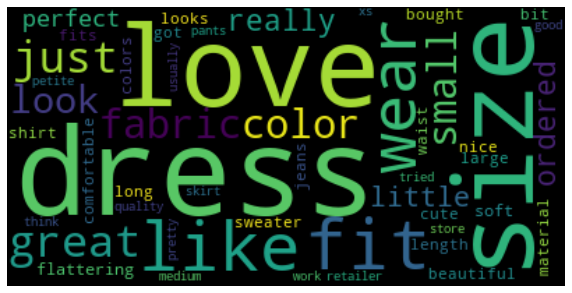

In [16]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(df['Review Text'], 50)
#for word, freq in common_words:
#    print(word, freq)
df2 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
df2_ = df2.set_index('ReviewText').to_dict()["count"]
# Create and generate a word cloud image:
wordcloud1 = wordcloud.WordCloud().generate_from_frequencies(df2_)

# Display the generated image:
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()


In [17]:
# df2.groupby('ReviewText').sum()['count'].sort_values(ascending=False).iplot(
#     kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in review after removing stop words')

### Top bigrams after removing stop words

(-0.5, 399.5, 199.5, -0.5)

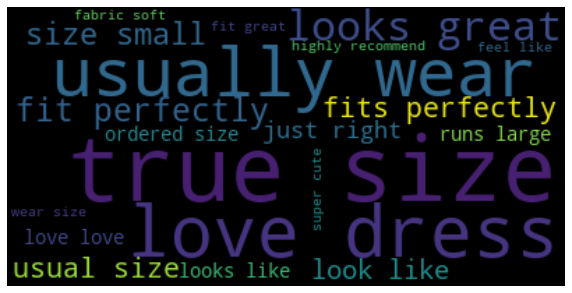

In [18]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(df['Review Text'], 20)
df3 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])

df3_ = df3.set_index('ReviewText').to_dict()["count"]
# Create and generate a word cloud image:
wordcloud1 = wordcloud.WordCloud().generate_from_frequencies(df3_)

# Display the generated image:
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

In [19]:
df2.groupby('ReviewText').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 bigrams in review after removing stop words')

### Top trigrams before removing stop words

In [20]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(df['Review Text'], 20)
for word, freq in common_words:
    print(word, freq)
df5 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])

true to size 1316
the fabric is 1291
this dress is 1115
the material is 886
in the store 728
on the model 725
the fit is 693
this top is 667
the color is 625
love this dress 605
tried it on 574
it is very 572
and it is 569
and it was 537
in the back 528
up or down 518
the dress is 511
to wear it 490
love this top 480
the colors are 472


In [21]:
df5.groupby('ReviewText').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 trigrams in review before removing stop words')

### Top trigrams after removing stop words

(-0.5, 399.5, 199.5, -0.5)

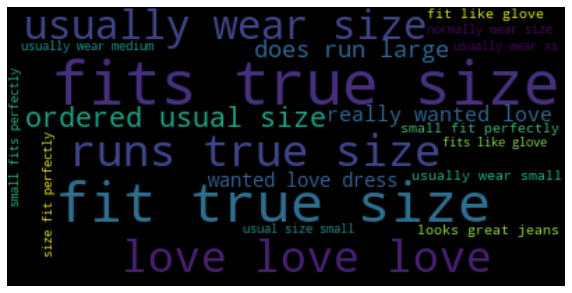

In [22]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus) 
    # vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(df['Review Text'], 20)
df6 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])

df6_ = df6.set_index('ReviewText').to_dict()["count"]
# Create and generate a word cloud image:
wordcloud1 = wordcloud.WordCloud().generate_from_frequencies(df6_)

# Display the generated image:
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

In [23]:
df6.groupby('ReviewText').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 trigrams in review after removing stop words')

We don't see any significant difference in terms of sentiment polarity between division names.

In [24]:
y0 = df.loc[df['Department Name'] == 'Tops']['polarity']
y1 = df.loc[df['Department Name'] == 'Dresses']['polarity']
y2 = df.loc[df['Department Name'] == 'Bottoms']['polarity']
y3 = df.loc[df['Department Name'] == 'Intimate']['polarity']
y4 = df.loc[df['Department Name'] == 'Jackets']['polarity']
y5 = df.loc[df['Department Name'] == 'Trend']['polarity']

trace0 = go.Box(
    y=y0,
    name = 'Tops',
    marker = dict(
        color = 'rgb(214, 12, 140)',
    )
)
trace1 = go.Box(
    y=y1,
    name = 'Dresses',
    marker = dict(
        color = 'rgb(0, 128, 128)',
    )
)
trace2 = go.Box(
    y=y2,
    name = 'Bottoms',
    marker = dict(
        color = 'rgb(10, 140, 208)',
    )
)
trace3 = go.Box(
    y=y3,
    name = 'Intimate',
    marker = dict(
        color = 'rgb(12, 102, 14)',
    )
)
trace4 = go.Box(
    y=y4,
    name = 'Jackets',
    marker = dict(
        color = 'rgb(10, 0, 100)',
    )
)
trace5 = go.Box(
    y=y5,
    name = 'Trend',
    marker = dict(
        color = 'rgb(100, 0, 10)',
    )
)
data = [trace0, trace1, trace2, trace3, trace4, trace5]
layout = go.Layout(
    title = "Sentiment Polarity Boxplot of Department Name"
)

fig = go.Figure(data=data,layout=layout)
iplot(fig, filename = "Sentiment Polarity Boxplot of Department Name")

In [25]:
y0 = df.loc[df['Department Name'] == 'Tops']['review_len']
y1 = df.loc[df['Department Name'] == 'Dresses']['review_len']
y2 = df.loc[df['Department Name'] == 'Bottoms']['review_len']
y3 = df.loc[df['Department Name'] == 'Intimate']['review_len']
y4 = df.loc[df['Department Name'] == 'Jackets']['review_len']
y5 = df.loc[df['Department Name'] == 'Trend']['review_len']

trace0 = go.Box(
    y=y0,
    name = 'Tops',
    marker = dict(
        color = 'rgb(214, 12, 140)',
    )
)
trace1 = go.Box(
    y=y1,
    name = 'Dresses',
    marker = dict(
        color = 'rgb(0, 128, 128)',
    )
)
trace2 = go.Box(
    y=y2,
    name = 'Bottoms',
    marker = dict(
        color = 'rgb(10, 140, 208)',
    )
)
trace3 = go.Box(
    y=y3,
    name = 'Intimate',
    marker = dict(
        color = 'rgb(12, 102, 14)',
    )
)
trace4 = go.Box(
    y=y4,
    name = 'Jackets',
    marker = dict(
        color = 'rgb(10, 0, 100)',
    )
)
trace5 = go.Box(
    y=y5,
    name = 'Trend',
    marker = dict(
        color = 'rgb(100, 0, 10)',
    )
)
data = [trace0, trace1, trace2, trace3, trace4, trace5]
layout = go.Layout(
    title = "Review length Boxplot of Department Name"
)

fig = go.Figure(data=data,layout=layout)
iplot(fig, filename = "Review Length Boxplot of Department Name")

### Sentiment Aggregation

Aggregation for the sentiment scores can be done by either/and on time and positive feedback count (something like 'thumbs-up'). Questions arise is if we want to weigh the sentiment score if there is zero feedback count. In this case, we weigh it by a lower weight.

In [26]:
df["Positive Feedback Count_"] = df["Positive Feedback Count"].map(lambda x : max(0.5, x))

# Here we sum up the total no of postiive feedback count in that week first
dfsent_feedbackcount = df.groupby(["WeekNo"], as_index=False)['Positive Feedback Count_'].sum()
dfsent_feedbackcount = dfsent_feedbackcount.rename(columns={'Positive Feedback Count_':"Sum_Feedback"})
df = df.merge(dfsent_feedbackcount, on="WeekNo", how="inner")
#dfsent_feedbackcount
df["Sentiment"] = df["Positive Feedback Count_"]/ df["Sum_Feedback"]*df["polarity"]

In [27]:
df_sentbyweek = df.groupby(["WeekNo"],as_index=False)['Sentiment'].sum()
df_buzzbyweek =  df.groupby(["WeekNo"], as_index=False)['Positive Feedback Count_'].count()
df_buzzbyweek = df_buzzbyweek.rename(columns={'Positive Feedback Count_':"Buzz"})

In [28]:
df_sentbyweek = df_sentbyweek.merge(df_buzzbyweek, on="WeekNo", how="inner")

Text(0.5, 0, 'Week No')

Text(0, 0.5, 'Sentiment')

Text(0, 0.5, 'Buzz: No of Reviews')

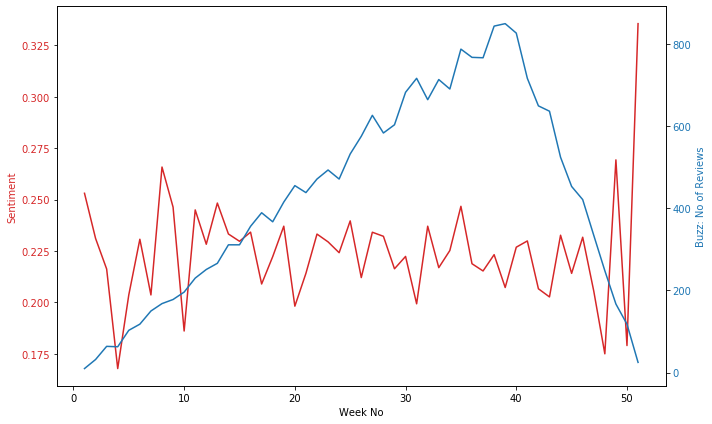

In [29]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Week No')
ax1.set_ylabel('Sentiment', color=color)
ax1.plot(df_sentbyweek["WeekNo"], df_sentbyweek["Sentiment"], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Buzz: No of Reviews', color=color)  # we already handled the x-label with ax1
ax2.plot(df_sentbyweek["WeekNo"], df_sentbyweek["Buzz"], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


### Exercise (optional)

- Perform the same exercise but instead of weighing the sentiment by number of likes, weigh it equally.
- Compute the buzz by the no of likes instead of the number of reviews.
- Also perform the exercise to visualise the sentiment by department. (Use heatmap from seaborne which was covered on Day 1.)

What difference will you observe?